In [15]:
import nibabel as nib
import matplotlib.pyplot as plt 

In [4]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

In [12]:
img_test = load_nifti_image('./test/site1-sc11-image.nii.gz')

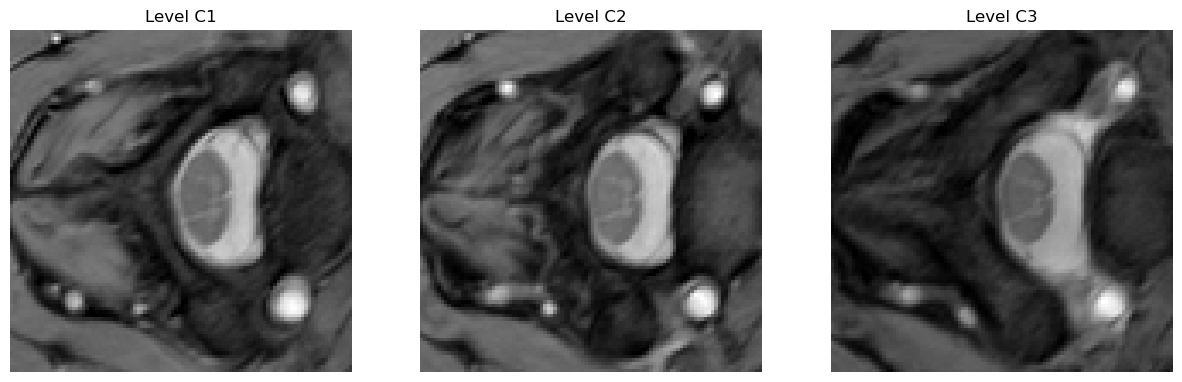

In [30]:
plt.figure(figsize=(15,6))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')